In [1]:
using Evolutionary
using Flux
using Flux: onehot, onecold, logitcrossentropy,onehotbatch, crossentropy 
using MLDatasets
using Random
#Sihao Ren // sren03 // 947105531
using Statistics
using MLJBase
using Printf
using BSON: @load # for load weights
using Plots
using DelimitedFiles
import Evolutionary.initial_population
using Zygote
import Evolutionary.NonDifferentiable


In [2]:
Random.seed!(63456345)


TaskLocalRNG()

In [16]:
rawdata = readdlm("data/test1.csv",',',skipstart=1)';
# one = 0
# zero = 0
# for i in rawdata[20,:]
#     if i == 1
#         one = one + 1
#     else
#         zero = zero + 1
#     end
# end

# difference = one - zero

# function newrand()
#     randCol = zeros(0)
#     push!(randCol, rand(10.0:99.0))
#     push!(randCol, rand(5.3:40.2))
#     push!(randCol, rand(1.1:15.1))
#     push!(randCol, rand(0.1:8.1))
#     push!(randCol, rand(1.1:15.1))
#     push!(randCol, rand(30.1:60.1))
#     push!(randCol, rand(0.1:0.9))
#     push!(randCol, rand(0.1:4.1))
#     push!(randCol, rand(20.1:50.1))
#     push!(randCol, rand(0.1:5.1))
#     push!(randCol, rand(0.1:7.1))
#     push!(randCol, rand(45.1:99.1))
#     push!(randCol, rand(0.1:5.1))
#     push!(randCol, rand(0.1:5.1))
#     push!(randCol, rand(0.1:7.1))
#     push!(randCol, rand(0.1:7.1))
#     push!(randCol, rand(0.1:3.1))
#     push!(randCol, rand(0.1:3.1))
#     push!(randCol, rand(0.1:5.1))
#     if rand(0:1) == 0
#         push!(randCol, 0.0)
#     else
#         push!(randCol, 1.0)
#     end
#     return randCol
# end

# for i = 1:size(rawdata,2)
#     if rawdata[20,i] == 0 && difference > 0
#         rawdata = hcat(rawdata, rawdata[:,i])
#         rawdata = hcat(rawdata, newrand())

#         difference = difference - 1
#     end
# end
# filldata = rawdata[ :, shuffle(1:end)];


In [20]:
filldata = rawdata

20×33 adjoint(::Matrix{Float64}) with eltype Float64:
 36.0  35.0  74.0  58.0  48.0  75.0  …  76.0  78.0  51.0  64.0  55.0  82.0
 27.4  26.9  15.3  11.6  11.5  11.4     22.5  22.0  20.7  20.3  20.3  19.6
  7.4   7.2   5.2   5.7   4.5   3.7      8.8  10.1   8.4   6.2  10.4   7.4
  2.6   2.0   2.0   2.3   1.6   1.5      3.8   3.9   3.2   2.4   4.3   3.1
  7.6   6.7   4.7   5.5   3.0   3.5      9.2   8.7   6.4   4.4   8.1   7.3
 34.7  29.6  42.2  42.6  52.4  42.3  …  41.5  44.7  49.7  55.2  52.9  41.9
  0.5   0.7   0.4   0.1   0.0   0.3      0.0   0.7   0.0   0.0   0.0   0.0
  2.1   2.8   1.7   0.5   0.1   1.1      0.1   1.8   0.0   0.0   0.0   0.3
 25.0  23.5  24.4  22.6   0.0  32.5      0.0  39.0   0.0   0.0   0.0   4.3
  1.6   2.6   0.9   0.9   1.3   0.4      1.2   1.6   2.0   1.4   1.8   1.2
  2.3   3.4   1.3   1.3   1.9   0.5  …   1.6   2.2   2.9   2.4   3.6   1.5
 69.9  76.5  67.0  68.9  67.4  73.2     73.6  74.1  66.7  57.2  51.5  80.6
  0.7   0.5   0.5   1.0   1.0   0.2      1.7  

In [19]:
rawdata[:,1]

20-element Vector{Float64}:
 36.0
 27.4
  7.4
  2.6
  7.6
 34.7
  0.5
  2.1
 25.0
  1.6
  2.3
 69.9
  0.7
  3.4
  4.1
  1.9
  0.4
  0.4
  1.3
  0.0

In [21]:
x = filldata[1:19, :]
y = filldata[20, :];

x_train = x[:,1:floor(Int, size(x,2)*0.7)]
y_train = y[1:floor(Int, size(x,2)*0.7)]
x_test = x[:,floor(Int, size(x,2)*0.7)+1:end]
y_test = y[floor(Int, size(x,2)*0.7)+1:end];

In [25]:
train_data = [ (x, onehot(l, unique(y_train))) for (x, l) in zip(eachcol(x_train), y_train)]
test_data = [ (x, onehot(l, unique(y_test))) for (x, l) in zip(eachcol(x_test), y_test)];


In [26]:
train_data

23-element Vector{Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, Flux.OneHotArray{UInt32, 2, 0, 1, UInt32}}}:
 ([36.0, 27.4, 7.4, 2.6, 7.6, 34.7, 0.5, 2.1, 25.0, 1.6, 2.3, 69.9, 0.7, 3.4, 4.1, 1.9, 0.4, 0.4, 1.3], [1, 0])
 ([35.0, 26.9, 7.2, 2.0, 6.7, 29.6, 0.7, 2.8, 23.5, 2.6, 3.4, 76.5, 0.5, 2.0, 2.4, 3.7, 1.1, 0.5, 1.6], [1, 0])
 ([74.0, 15.3, 5.2, 2.0, 4.7, 42.2, 0.4, 1.7, 24.4, 0.9, 1.3, 67.0, 0.5, 1.7, 2.2, 1.0, 0.5, 0.3, 1.0], [1, 0])
 ([58.0, 11.6, 5.7, 2.3, 5.5, 42.6, 0.1, 0.5, 22.6, 0.9, 1.3, 68.9, 1.0, 0.9, 1.9, 0.8, 0.6, 0.1, 1.0], [0, 1])
 ([48.0, 11.5, 4.5, 1.6, 3.0, 52.4, 0.0, 0.1, 0.0, 1.3, 1.9, 67.4, 1.0, 1.5, 2.5, 0.3, 0.3, 0.4, 0.8], [0, 1])
 ([75.0, 11.4, 3.7, 1.5, 3.5, 42.3, 0.3, 1.1, 32.5, 0.4, 0.5, 73.2, 0.2, 0.7, 0.8, 1.8, 0.4, 0.0, 0.7], [1, 0])
 ([62.0, 10.9, 6.6, 2.5, 5.8, 43.5, 0.0, 0.1, 50.0, 1.5, 1.8, 81.1, 0.5, 1.4, 2.0, 0.6, 0.2, 0.1, 0.7], [0, 1])
 ([48.0, 10.3, 5.7, 2.3, 5.4, 41.5, 0.4, 1.5, 30.0, 0.7, 0

In [27]:
x_train[:,1]

19-element Vector{Float64}:
 36.0
 27.4
  7.4
  2.6
  7.6
 34.7
  0.5
  2.1
 25.0
  1.6
  2.3
 69.9
  0.7
  3.4
  4.1
  1.9
  0.4
  0.4
  1.3

In [5]:
#dataset = Flux.Data.DataLoader((x_train, y_train), batchsize=1) 

Flux.Data.DataLoader{Tuple{Matrix{Float64}, Flux.OneHotArray{UInt32, 2, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}(([66.0 64.0 … 79.0 66.0; 21.4 17.3 … 13.4 27.2; … ; 1.0 0.4 … 0.3 0.3; 0.7 0.9 … 0.7 1.8], Bool[1 0 … 0 0; 0 1 … 1 1]), 1, 1388, true, 1388, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388], false, Random._GLOBAL_RNG())

In [28]:
# loss(x, y) = crossentropy(model(x), y) 
# # optim = Descent(0.1)
# # optim = ADAM()
# accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy(model,x,y) = mean(onecold(model(x)) .== onecold(y))
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)

loss(model) = (x,y)->logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))

loss (generic function with 3 methods)

In [29]:
fitness(m) = loss(train_data, m)

fitness (generic function with 1 method)

In [30]:
l1 = Dense(19, 2*19, sigmoid)
l2 = Dense(2*19, 2)
model = Chain(l1, l2)


Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [9]:
loadpath = string("models/model",2,".bson")
@load loadpath weights
Flux.loadparams!(model, weights)

In [31]:
fitness(model)

0.6653784063182596

In [35]:
softmax(model(x_train[:,6]))

2-element Vector{Float64}:
 0.2804804784661032
 0.7195195215338968

In [36]:
function uniform_mlp(m1::T, m2::T) where {T <: Chain}
    θ1, re1 = Flux.destructure(m1);
    θ2, re2 = Flux.destructure(m2);
    c1, c2 =uniform(θ1,θ2)
    return re1(c1), re2(c2)
end

uniform_mlp (generic function with 1 method)

In [37]:
uniform_mlp(model, model)

(Chain(Dense(19, 38, σ), Dense(38, 2)), Chain(Dense(19, 38, σ), Dense(38, 2)))

In [38]:
function gaussian_mlp(σ::Real = 1.0)
    vop = gaussian(σ)
    function mutation(recombinant::T) where {T <: Chain}        
        θ, re = Flux.destructure(recombinant)
        return re(convert(Vector{Float32}, vop(θ)))
    end
    return mutation
end

gaussian_mlp (generic function with 2 methods)

In [27]:
gaussian_mlp(0.5)(model)

Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [39]:
function initial_population(method::M, individual::Chain) where {M<:Evolutionary.AbstractOptimizer}
    θ, re = Flux.destructure(individual);
    [re(randn(length(θ))) for i in 1:Evolutionary.population_size(method)]
end

initial_population (generic function with 6 methods)

In [40]:
NonDifferentiable(f, x::Chain) = NonDifferentiable{Real,typeof(x)}(f, f(x), deepcopy(x), [0,])

NonDifferentiable

In [30]:
NonDifferentiable(fitness, model)

NonDifferentiable{Real, Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(fitness, 0.9592131483511529, Chain(Dense(19, 38, σ), Dense(38, 2)), [0])

In [41]:
import Base: copy, copyto!
copy(ch::Chain) = deepcopy(ch)

function copyto!(l1::Dense{T}, l2::Dense{T}) where {T}
    copyto!(l1.W, l2.W)
    copyto!(l1.b, l2.b)
    l1
end

function copyto!(ch1::Chain, ch2::Chain)
    for i in 1:length(ch1.layers)
        copyto!(ch1.layers[i],ch2.layers[i])
    end
    ch1
end


copyto! (generic function with 140 methods)

In [42]:
opts = Evolutionary.Options(iterations=1, show_every=10, show_trace=false, store_trace=false)

                  abstol = 1.0e-32
                  reltol = 1.0e-32
        successive_f_tol = 10
              iterations = 100
             store_trace = true
              show_trace = true
              show_every = 10
                callback = nothing


In [67]:
algo = GA(
        selection = rouletteinv,
        mutation =  gaussian_mlp(2.0),
        crossover = uniform_mlp,
        mutationRate = 2.0,
        crossoverRate = 0.95,
        populationSize = 1000,
        ε = 0.000002
    )

GA(1000, 0.95, 2.0, 2.0e-6, Evolutionary.rouletteinv, uniform_mlp, var"#mutation#23"{Evolutionary.var"#mutation#29"{Float64}}(Evolutionary.var"#mutation#29"{Float64}(2.0)))

In [88]:
res = Evolutionary.optimize(fitness, evomodel, algo, opts)
evomodel= Evolutionary.minimizer(res)
@info "MLP" loss=loss(train_data, evomodel) accuracy = accuracy(train_data, evomodel)

Iter     Function value
     0   1.5006203697162723
 * time: 0.0009999275207519531


    10   0.5019702531741774
 * time: 1.4470000267028809


    20   0.4885650522969209
 * time: 2.3999998569488525


    30   0.49752150691439645
 * time: 3.3550000190734863


    40   0.49260840627095354
 * time: 4.336999893188477


    50   0.5166558553933048
 * time: 5.3999998569488525


    60   0.47522921152512615
 * time: 6.444000005722046


    70   0.49119486075774516
 * time: 7.639999866485596


    80   0.4660619305042051
 * time: 8.803999900817871


    90   0.48378619151270325
 * time: 10.047999858856201


   100   0.4745392152687743
 * time: 11.325999975204468


┌ Info: MLP
│   loss = 0.4745392152687743
│   accuracy = 0.782608695652174
└ @ Main c:\Users\xkzmx\Documents\Odyssey\School\Evolution\HW2\testField.ipynb:3


In [104]:
opts = Evolutionary.Options(iterations=1, show_every=10, show_trace=false, store_trace=false)
algo = GA(
        selection = rouletteinv,
        mutation =  gaussian_mlp(2.0),
        crossover = uniform_mlp,
        mutationRate = 2.0,
        crossoverRate = 0.95,
        populationSize = 100,
        ε = 0.000002
    )
myaccuracy(model,x,y) = mean(onecold(model(x)) .== onecold(y))


myaccuracy (generic function with 2 methods)

In [105]:
epochs = 50 # the number of epochs
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);

for i in 1:10
    l1 = Dense(19, 2*19, sigmoid)
    l2 = Dense(2*19, 2)
    model = Chain(l1, l2)

    loadpath = string("models/model",i,".bson")
    @load loadpath weights
    Flux.loadparams!(model, weights)
    res = Evolutionary.optimize(fitness, evomodel, algo, opts)
    evomodel= Evolutionary.minimizer(res)

    for j in 1:epochs
        res = Evolutionary.optimize(fitness, evomodel, algo, opts)
        evomodel= Evolutionary.minimizer(res)
        # if j%(epochs/5) == 0
        # #@printf("Loss in expirment %d epoch: %d in test data is %f\n",i, j, loss(x_test, y_test))
        # end
        save_resultTest[j] = save_resultTest[j] + accuracy(test_data, evomodel)
        save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, evomodel)
    end
end

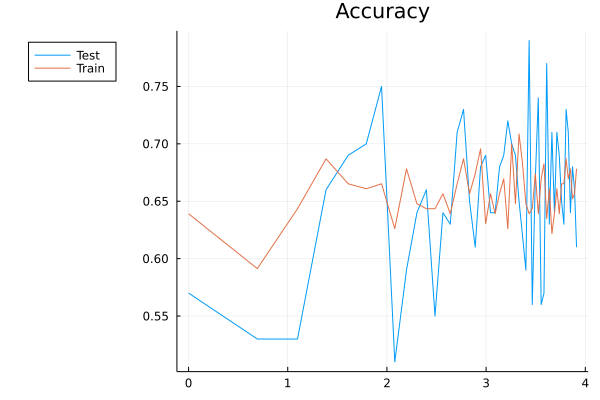

In [106]:
save_resultTest = save_resultTest ./ 10;
save_resultTrain = save_resultTrain ./ 10;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [75]:
evomodel= Evolutionary.minimizer(res)
@info "MLP" loss=loss(train_data, evomodel) accuracy = accuracy(train_data, evomodel)

┌ Info: MLP
│   loss = 0.4921319489784658
│   accuracy = 0.7391304347826086
└ @ Main c:\Users\xkzmx\Documents\Odyssey\School\Evolution\HW2\testField.ipynb:2


In [48]:
model = Chain(l1,l2)


Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [76]:
softmax(evomodel(x_train[:,9]))

2-element Vector{Float64}:
 0.8403408239664493
 0.15965917603355062

In [107]:

simplified_x_train_result = []
for i  = 1:size(x_train,2)
    if softmax(evomodel(x_train[:,i]))[1]>0.5
        push!(simplified_x_train_result, 0)
    else
        push!(simplified_x_train_result, 1)
    end
end
simplified_y_train = []
for i  = 1:size(x_train,2)
    if y_train[i] == 0
        push!(simplified_y_train, 0)
    else
        push!(simplified_y_train, 1)
    end
end

# ConfusionMatrix for the training data
print("ConfusionMatrix for the training data\n")
ConfusionMatrix()(simplified_x_train_result, simplified_y_train)

ConfusionMatrix for the training data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │      2      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │      9      │     12      │
└─────────────┴─────────────┴─────────────┘


In [60]:
for i in 1:23
    print((model(x_train[:,i])))
    print('\n')
end

[0.634074380734883, 1.1161675214320417]
[0.9251472480170928, 0.8073897183541174]
[0.42049145212809047, 1.3216734600799558]
[0.30054598690554235, 1.6955905046950979]
[0.35325713087874905, 2.1520624725338138]
[0.40463753494184973, 1.3467170659298422]
[0.35977629303730396, 1.6057767579070787]
[0.7813651164114997, 1.221310928077243]
[0.49704703567700814, 1.3396887031537579]
[0.37347004165151004, 1.6676678473596458]
[0.8856012174210159, 1.1089900437245652]
[0.7342445618835859, 1.355323905125478]
[0.9457201700633723, 1.5654504398647235]
[0.9787416779865429, 0.8708931163311197]
[0.6072744970714061, 2.169919575689136]
[0.3062289036603157, 2.2572563464601805]
[0.8238293449224913, 1.663112752806435]
[0.7964294910746541, 1.2259733100958283]
[0.47989830608638795, 1.3564487609544367]
[0.47989830608638795, 1.3564487609544367]
[0.5633837295627283, 1.5771411614171758]
[0.4812386013770091, 1.4002194580801879]
[0.4923819149894817, 1.3713866056190442]


2-element Vector{Float64}:
 -0.5717271551456502
 -0.4672532170740528

In [108]:
simplified_x_test_result = []
for i  = 1:size(x_test,2) 
    if softmax(evomodel(x_test[:,i]))[1]>0.5
        push!(simplified_x_test_result, 0)
    else
        push!(simplified_x_test_result, 1)
    end
end
simplified_y_test = []
for i  = 1:size(x_test,2) 
    if y_test[i] == 0
        push!(simplified_y_test, 0)
    else
        push!(simplified_y_test, 1)
    end
end

# ConfusionMatrix for the test data
print("ConfusionMatrix for the test data\n")
ConfusionMatrix()(simplified_x_test_result, simplified_y_test)

ConfusionMatrix for the test data


┌ Warning: The classes are un-ordered,
│ using: negative='1' and positive='0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │      6      │      4      │
├─────────────┼─────────────┼─────────────┤
│      0      │      0      │      0      │
└─────────────┴─────────────┴─────────────┘
